In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from astropy import constants as const
from astropy import units as u
from astropy.time import Time
from astropy.table import Table

import sys
sys.path.append('/Users/james/Dropbox/python/cubehelix/')
import cubehelix

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
CMAP1 = cubehelix.cmap(start=0.5, rot=-0.6, sat=1.8, reverse=True)
CMAP2 = cubehelix.cmap(start=1.5, rot=-0.6, sat=1.8, reverse=True)

In [35]:
# SN 2023ixf Properties: https://www.wis-tns.org/object/2023ixf/discovery-cert
# distance from Cepheids: https://ned.ipac.caltech.edu/reflookup?refcode=2013ApJ...777...79M
d0 = 6.19 * u.Mpc

t0 = Time(2460084.2272569, format='jd')
c0 = SkyCoord(ra=210.91075*u.deg, dec=54.311694*u.deg, frame='icrs', distance=d0)

In [19]:
# https://arxiv.org/abs/2012.02061
GCNS_file = '/Users/james/Dropbox/research_projects/lonely_stars/GCNS_cat.fits'
GCNS = Table.read(GCNS_file, format='fits')

# past me already did this, yay! 
# https://github.com/jradavenport/lonely_stars/blob/main/GCNS_KDTree.ipynb
c1 = SkyCoord(ra = GCNS['RA'] * u.degree,
              dec = GCNS['DEC'] * u.degree,
              distance= GCNS['DIST_50'] * u.kpc,
              frame='icrs')

len(GCNS)
# xyz = c1.transform_to(coord.Galactocentric)

331312

In [20]:
t1 = Time.now()
# t1 = Time({'year': 2088, 'month': 2, 'day': 23}, format='ymdhms')
dt = t1-t0

# dt.sec
# dt.jd
dt.to('year')

<Quantity 0.01096792 yr>

In [21]:
c = d0.to('lyr') / 2 # dist to foci from ellipse center
a = (((dt.to('s') * const.c) / 2) + c).to('lyr') # the semi-major axis of ellipse
print(a-c)

d1 = (GCNS['DIST_50'] * u.kpc) # dist to GCNS stars

d2 = c1.separation_3d(c0)

0.005483957007527351 lyr


In [22]:
# A few things to compute for each GCNS object:

# 1. has it seen SN  yet?
SNYES = d2.to('lyr').value <= (d0.to('lyr') + (dt.to('s') * const.c)).to('lyr').value
SNNO = ~SNYES

# 2. is it within the "SETI ellipse"?
EYES = (d1.to('lyr').value + d2.to('lyr').value) <= (2 * a.to('lyr').value)
ENO = ~EYES

# 3. is it within some tolerance of being ON the ellipse?
#    this could be within some range in distance or in time, thanks to speed of light...
tol = 0.1 # in lyr
OYES = np.abs((d1.to('lyr').value + d2.to('lyr').value) - (2 * a.to('lyr').value)) <= tol

In [32]:
print(len(d1))
print(sum(SNYES), sum(SNNO))
print('inside ellipsoid:', sum(EYES))
print('within tol of surface:', sum(OYES))
# print(sum(SNYES) / (sum(SNYES) + sum(SNNO)))
# print(sum(SNNO) / (sum(SNYES) + sum(SNNO)))
# print(sum(EYES) / (sum(SNYES) + sum(SNNO)))

331312
164612 166700
inside ellipsoid: 8
within tol of surface: 92


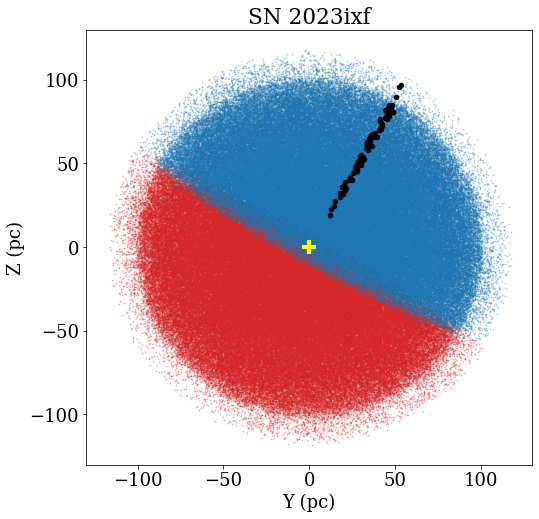

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(GCNS['YCOORD_50'][SNNO], GCNS['ZCOORD_50'][SNNO], c='C3', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.scatter([0],[0], c='yellow', marker='+', s=180, lw=4)
plt.title('SN 2023ixf')
plt.xlabel('Y (pc)')
plt.ylabel('Z (pc)')
# plt.grid(True)
plt.xlim(-130,130)
plt.ylim(-130,130)
plt.savefig('SN2023ixf.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

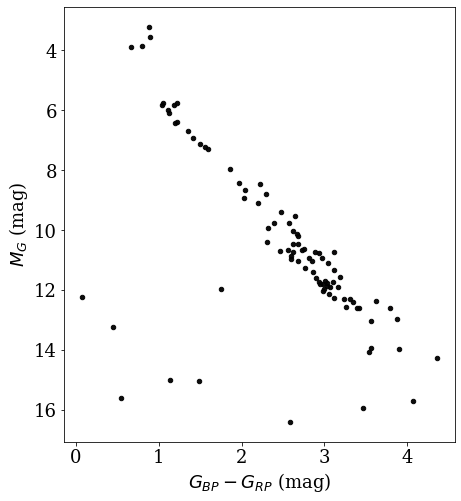

In [34]:
plt.figure(figsize=(7,8))

# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNNO] - GCNS['PHOT_RP_MEAN_MAG'][SNNO],
#             GCNS['PHOT_G_MEAN_MAG'][SNNO] - 5.*np.log10(GCNS['DIST_50'][SNNO]*1000)+5, 
#             c='C3', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][SNYES] - GCNS['PHOT_RP_MEAN_MAG'][SNYES],
#             GCNS['PHOT_G_MEAN_MAG'][SNYES] - 5.*np.log10(GCNS['DIST_50'][SNYES]*1000)+5, 
#             c='C0', s=1, alpha=0.25, rasterized=True)

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][EYES] - GCNS['PHOT_RP_MEAN_MAG'][EYES],
            GCNS['PHOT_G_MEAN_MAG'][EYES] - 5.*np.log10(GCNS['DIST_50'][EYES]*1000)+5, 
            c='C6', s=4, alpha=0.5, rasterized=True)

plt.scatter(GCNS['PHOT_BP_MEAN_MAG'][OYES] - GCNS['PHOT_RP_MEAN_MAG'][OYES],
            GCNS['PHOT_G_MEAN_MAG'][OYES] - 5.*np.log10(GCNS['DIST_50'][OYES]*1000)+5, 
            c='k', s=20, alpha=0.95, rasterized=True)

# yerr = 
# xerr = GCNS['']

# plt.scatter(GCNS['YCOORD_50'][SNYES],GCNS['ZCOORD_50'][SNYES], c='C0', s=1, alpha=0.25, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][EYES], GCNS['ZCOORD_50'][EYES], c='C6', s=4, alpha=0.5, rasterized=True)
# plt.scatter(GCNS['YCOORD_50'][OYES], GCNS['ZCOORD_50'][OYES], c='k', s=20, alpha=0.95, rasterized=True)

plt.gca().invert_yaxis()

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
# plt.xlim(-130,130)
# plt.ylim(-130,130)
plt.savefig('SN2023ixf_CMD_on.png', dpi=150, bbox_inches='tight', pad_inches=0.25)